<a href="https://colab.research.google.com/github/AlexandraLutaya/neural-networks-for-forecasting/blob/main/%D0%9F%D1%80%D0%B8%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9_%D0%B4%D0%BB%D1%8F_%D0%BF%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B0_%D1%80%D0%B0%D0%B7%D0%B2%D0%B8%D1%82%D0%B8%D1%8F_%D0%A1%D0%A1%D0%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Применение нейронных сетей и методов глубокого обучения для прогнозирования развития сердечно-сосудистых заболеваний


В статье  [An artificial intelligence model for heart disease detection using machine learning algorithms](https://www.sciencedirect.com/science/article/pii/S2772442522000016) расматривается возможность применения машинного обучения для прогноза развития сердечно-сосудистых заболеваний. В статье основной акцент сделан на алгоритм случайного леса.

В своем исследовании так же изучим применение данного алгоритма, но так же применим методы глубокого обучения.

##Загрузка библиотек и написание собственных функций

In [1]:
pip install --upgrade gdown

In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, precision_score, recall_score
from sklearn.inspection import permutation_importance

from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore', module='pandas')
warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipython-input-4112232649.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
#функция для изучения данных на аномальные значения и попуски
#функция принимает на вход DataFrame, выводит текстовые сообщения на консоль
def anomaly(data):
  #сли передан Series, преобразуем его в DataFrame
  if isinstance(data, pd.Series):
    data = data.to_frame()
  #выводим размер датасета
  print(f'Размер файла:{data.shape}')
  print('-'*100)
  #для вывода всех столбцов создаем цикл
  #выделяем в отдельную переменную названия столбцов
  column_data= data.columns
  #циклом перебираем все значения и выводим данные
  for c in column_data:
    #выводим все уникальные значения
    print(f'Уникальные значения показателя: {c}')
    print(data[c].unique())
    #считаем количество уникальных значений
    print(f'Количество уникальных значений: {data[c].nunique()}')
    #считаем количество всех значений
    print(f'Количество всех значений: {data[c].count()}')
    #считаем количество пропусков
    print(f'Количество пропусков в столбце {c}: {data[c].isna().sum()}')
    print('-'*100)

In [4]:
#функция для оценки пропусков в данных
#функция принимает на вход DataFrame, выводит текстовые сообщения на консоль
def nan_counts(df):
  #считаем количество пропусков в строке
  nan_counts = df.isna().sum(axis=1)
  #проверяем, какие строки имеют более половины NaN
  half_nan_rows = nan_counts > len(df.columns) / 2
  #количество строк с более чем половиной NaN
  num_half_nan_rows = half_nan_rows.sum()
  #вывод результатов
  print(f"\nОбщее количество строк с более чем половиной NaN: {num_half_nan_rows}")

In [5]:
#функция для исследовательского анализа количественных данных
#функция принимает на вход DataFrame (количественные данные), выводит графики на консоль
def analisys_num(data):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    #настраиваем построение гистограммы
    axes[0].hist(data.dropna(), bins=20)
    axes[0].set_title('Гистограмма показателя')
    axes[0].set_xlabel('Значения показателя')
    #визуально выводим среднее значение и медиану
    axes[0].axvline(data.median(), color='b', linestyle='dashed', linewidth=2)
    axes[0].axvline(data.mean(), color='r', linestyle='solid', linewidth=2)
    axes[0].legend(['Медиана', 'Среднее', 'Мода'], prop={'size': 6})

    #постройка боксплота для данных
    axes[1].set_title('Боксплот показателя')
    axes[1].boxplot(data.dropna())
    #настройка скрипичной диаграммы
    axes[2].set_title('Скрипичная диаграмма показателя')
    axes[2].violinplot([data.dropna()], vert=False, widths=0.75,
                       showmeans=True, showmedians=True)
    plt.tight_layout()
    plt.show()
    #выводим статистику по показателю
    print('Показатели описательной статистики')
    print(data.describe())
    print(f'Мода в данных по показателю: {data.mode()}')

In [6]:
#функция для исследовательского анализа качественных данных с использованием круговой диаграммы
#функция принимает данные и считает их количество внутри каждого уникального значения,
#после выводит круговой график
#функция принимает на вход DataFrame, выводит графики на консоль
def analisys_cat_pie(data, labels=None):
    if labels is not None:
      data = data.map(labels)

    data.value_counts().plot(kind='pie', autopct='%.2f%%', figsize=(5, 5))
    plt.title('Круговая диаграмма показателя', size=10)
    plt.show()

In [7]:
#функция для исследовательского анализа качевтенных данных с использованием столбчатой диаграммы
#функция принимает данные и считает их количество внутри каждого уникального значения,
#после выводит столбчатую диаграмму
#функция принимает на вход DataFrame, выводит графики на консоль
def analisys_cat_plot(data):
    data.value_counts(ascending=True).plot(kind='bar', alpha=0.8)
    plt.title('Столбчатая диаграмма', size=15)
    plt.xlabel('Количество', size=12)
    plt.ylabel('Значения', size=12)
    plt.show()

In [8]:
#функция для вывода графика Lmplot
#функция принимает датасет и названия столбцов, по которым надо построить график
#функция принимает на вход DataFrame, выводит графики сообщения на консоль
def grafic(data, x, y):
    sns.lmplot(x=x, y=y, data=data)
    plt.title(f'Зависимость показателя {y} от показателя {x}', size=10)
    plt.xlabel(f'Показатель {x}', size=8)
    plt.ylabel(f'Показатель {y}', size=8)
    plt.show()

In [9]:
#функция для изучения распределния показателя в группах по целевому признаку
#функция принимает числовые данные для каждой группы и строит боксплот
def target_sigh(data, target_col, sign_col):
  sns.boxplot(x=target_col, y=sign_col, data=data)
  plt.title(f'Сравнение показателя {sign_col} у пациентов\nбез заболевания (0) и с заболеванием (1)')
  plt.xlabel('Показатель')
  plt.show()

In [10]:
#функция для изучения распределения категориального фактора внутри группы целевого признака
#функция принимает количество категориальых данных в группе и строит гистограмму
def target_group(data, target_col, sign_col):
  plot_grouped_data(data, group_cols=[target_col, sign_col],
      rename_dict={
          'index': {0: 'Нет', 1: 'Есть'}
      }
  )
  plt.show()

In [11]:
#функция для построения гистограммы для сравнения распространения признака в двух группах
def plot_grouped_data(dataframe, group_cols, rename_dict=None):
    grouped_data = dataframe.groupby(group_cols).size().unstack(fill_value=0)

    if rename_dict is not None:
        grouped_data.rename(columns=rename_dict.get('columns'), index=rename_dict.get('index'), inplace=True)

    plt.figure(figsize=(10, 6))
    grouped_data.plot(kind='bar', stacked=True, colormap='tab10')

    plt.xlabel(f'Категория {group_cols[0]}')
    plt.ylabel('Количество записей')
    plt.title(f'{group_cols[0]} vs {group_cols[1]}')
    plt.legend(title=f'{group_cols[1]}', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [12]:
#напишем функцию для общей оценки эффективности модели на тестовых данных
def score_model(model, X_test, y_test):
  print('Оценка ROC-AUC на тестовых данных для лучшей модели')
  #получаем массив вероятностей принадлежности объектов к каждому классу и выбираем только положительные реультаты
  probs = model.predict_proba(X_test)[:, 1]
  #вычисляем ложноположительные, истинноположительные и пороги
  fpr, tpr, _ = roc_curve(y_test, probs)
  #вычисляем площадь под ROC-кривой
  roc_auc = auc(fpr, tpr)
  print(f'Значение ROC-AUC на тестовых данных: {roc_auc:.4f}')
  #настраиваем график
  plt.figure(figsize=(7, 6))
  lw = 2
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Доля ложноположительных (FPR)')
  plt.ylabel('Доля истинноположительных (TPR)')
  plt.title('График ROC')
  plt.legend(loc="lower right")
  plt.show()

  print('Построение матрицы ошибок для лучшей модели')
  #получаем предсказание
  preds = model.predict(X_test)
  #получаем матрицу
  cm = confusion_matrix(y_test, preds)
  #натсраиваем график
  plt.figure(figsize=(7, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Предсказанные значения')
  plt.ylabel('Истинные значения')
  plt.title('Матрица ошибок')
  plt.show()

##Загрузка данных и их первичное изучение

In [13]:
! gdown 116a-UW-VSNveTeM1tSL5ROQ3Vguf1-Sw

Downloading...
From: https://drive.google.com/uc?id=116a-UW-VSNveTeM1tSL5ROQ3Vguf1-Sw
To: /content/train.csv
100% 53.8M/53.8M [00:00<00:00, 144MB/s]


In [14]:
! gdown 1TAnHw6cXcMRUyI333-uEdeGS9JZWBAUr

Downloading...
From: https://drive.google.com/uc?id=1TAnHw6cXcMRUyI333-uEdeGS9JZWBAUr
To: /content/test.csv
100% 35.1M/35.1M [00:00<00:00, 67.9MB/s]


In [15]:
train = pd.read_csv('/content/train.csv')

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 15 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ID                                    600000 non-null  int64  
 1   age                                   600000 non-null  float64
 2   sex                                   600000 non-null  int64  
 3   chest                                 600000 non-null  float64
 4   resting_blood_pressure                600000 non-null  float64
 5   serum_cholestoral                     600000 non-null  float64
 6   fasting_blood_sugar                   600000 non-null  int64  
 7   resting_electrocardiographic_results  600000 non-null  int64  
 8   maximum_heart_rate_achieved           600000 non-null  float64
 9   exercise_induced_angina               600000 non-null  int64  
 10  oldpeak                               600000 non-null  float64
 11  

In [17]:
train.head(4)

,ID,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,class
0,0,49.207124,0,4.000000,162.996167,181.108682,0,0,148.227858,1,0.944547,2,0,3,1
1,1,53.628425,1,1.741596,130.233730,276.474630,0,2,152.917139,0,0.119070,2,0,3,0
2,2,49.591426,1,4.000000,146.999012,223.300517,1,2,102.352090,1,1.616747,2,2,7,1
3,3,58.991445,1,4.000000,112.369143,187.245501,0,0,158.164750,1,0.000000,1,1,7,1


In [18]:
test = pd.read_csv('/content/test.csv')

In [19]:
test.head(4)

,ID,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal
0,600000,53.963191,1,4.000000,136.940829,236.862814,0,2,143.961525,1,0.711100,1,2,7
1,600001,49.621479,1,4.000000,122.024651,226.593019,0,2,112.220874,1,0.000000,1,1,7
2,600002,36.933893,1,1.300924,127.585643,351.061046,0,0,177.945922,0,0.313078,1,0,7
3,600003,54.884588,1,3.000000,124.876745,250.370530,0,0,153.176526,0,0.308277,1,1,7


In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 14 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ID                                    400000 non-null  int64  
 1   age                                   400000 non-null  float64
 2   sex                                   400000 non-null  int64  
 3   chest                                 400000 non-null  float64
 4   resting_blood_pressure                400000 non-null  float64
 5   serum_cholestoral                     400000 non-null  float64
 6   fasting_blood_sugar                   400000 non-null  int64  
 7   resting_electrocardiographic_results  400000 non-null  int64  
 8   maximum_heart_rate_achieved           400000 non-null  float64
 9   exercise_induced_angina               400000 non-null  int64  
 10  oldpeak                               400000 non-null  float64
 11  

Датасеты содержат следующие данные:

1. ID - идентификатор пациента;

2. Age - возраст;

3. Sex - пол;

4. Resting_blood_pressure - артериальное давление в состоянии покоя;

5. Serum_cholestoral - уровень холестерина в крови mg/dl;

6. Fasting_blood_sugar - анализ глюкозы в крови натощак (> 120 mg/dl);

7. Maximum_heart_rate_achieved - максимальная частота сердечных сокращений;

9. Exercise_induced_angina - стенокардия при нагрузке,

10. Oldpeak - депрессия ST-сегмента;

11. Slope - наклон пикового сегмента ST при физической нагрузке;

12. Number_of_major_vessels - количество крупных сосудов (0-3), окрашенных с помощью флюороскопии;

13. Resting_electrocardiographic_results - результаты электрокардиографических исследований в покое 0, 1, 2;

14. Thal - 3 = норма; 6 = фиксированный дефект; 7 = обратимый дефект;

15. Chest - боль в груди от 1 до 4.

В обучающем датасете есть так же целевой пизнак. В тестовом датасете нет класса, то есть после получения лучшей модели на обучающем датасете нет возможности оценить метрики и сделать вывод об переученности или недоученности модели.

##Предобработка данных

Задачи:

1. Провести исследования данных на явные дубликаты

2. Провести исследования данных на предмет пропусков и изучить их необходимость замены или удаления.

3. Провести исследование данных на предмет неинформативных строк (строк с более, чем половина пропусков)

Основная часть предобработки будет затронут обучающий датасет. В тестовый датасет будет оценен на грубые опечатки.

In [21]:
before_clean = len(train)

In [22]:
anomaly(train)

Размер файла:(600000, 15)
----------------------------------------------------------------------------------------------------
Уникальные значения показателя: ID
[     0      1      2 ... 599997 599998 599999]
Количество уникальных значений: 600000
Количество всех значений: 600000
Количество пропусков в столбце ID: 0
----------------------------------------------------------------------------------------------------
Уникальные значения показателя: age
[49.207124 53.628425 49.591426 ... 41.579352 53.716562 62.166853]
Количество уникальных значений: 594106
Количество всех значений: 600000
Количество пропусков в столбце age: 0
----------------------------------------------------------------------------------------------------
Уникальные значения показателя: sex
[0 1]
Количество уникальных значений: 2
Количество всех значений: 600000
Количество пропусков в столбце sex: 0
----------------------------------------------------------------------------------------------------
Уникальные значения

In [23]:
nan_counts(train)


Общее количество строк с более чем половиной NaN: 0


In [24]:
train.duplicated().sum()

np.int64(0)

In [25]:
anomaly(test)

Размер файла:(400000, 14)
----------------------------------------------------------------------------------------------------
Уникальные значения показателя: ID
[600000 600001 600002 ... 999997 999998 999999]
Количество уникальных значений: 400000
Количество всех значений: 400000
Количество пропусков в столбце ID: 0
----------------------------------------------------------------------------------------------------
Уникальные значения показателя: age
[53.963191 49.621479 36.933893 ... 55.530874 55.442225 60.638052]
Количество уникальных значений: 397391
Количество всех значений: 400000
Количество пропусков в столбце age: 0
----------------------------------------------------------------------------------------------------
Уникальные значения показателя: sex
[1 0]
Количество уникальных значений: 2
Количество всех значений: 400000
Количество пропусков в столбце sex: 0
----------------------------------------------------------------------------------------------------
Уникальные значения

In [26]:
nan_counts(test)


Общее количество строк с более чем половиной NaN: 0


In [27]:
test.duplicated().sum()

np.int64(0)

In [28]:
train['age'] = train['age'].astype(int)

In [29]:
test['age'] = test['age'].astype(int)

**Выводы по разделу:**

Данные не соджержат выбросов, пропусков и явных дубликатов. В связи с этим серьезная предобработка данных не требуется. Только перевели значение возраста в целые значения.

##Исследовательский анализ данных

In [30]:
train.columns

Index(['ID', 'age', 'sex', 'chest', 'resting_blood_pressure',
       'serum_cholestoral', 'fasting_blood_sugar',
       'resting_electrocardiographic_results', 'maximum_heart_rate_achieved',
       'exercise_induced_angina', 'oldpeak', 'slope',
       'number_of_major_vessels', 'thal', 'class'],
      dtype='object')

In [31]:
bool_col= ['sex', 'fasting_blood_sugar', 'exercise_induced_angina', 'class']

cat_col =['resting_electrocardiographic_results', 'slope', 'number_of_major_vessels', 'thal']

num_col = ['age', 'resting_blood_pressure','maximum_heart_rate_achieved', 'serum_cholestoral', 'oldpeak', 'chest']

Исследовательский анализ показателя age


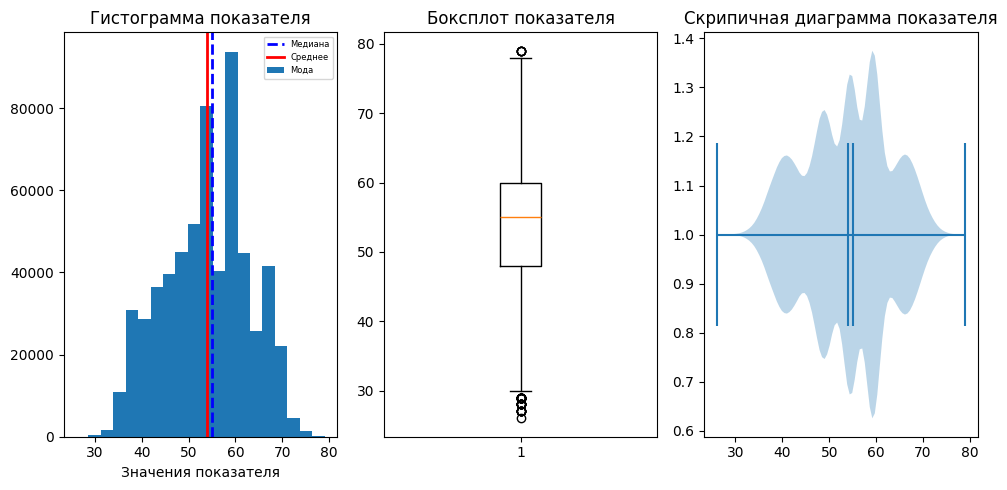

Показатели описательной статистики
count    600000.000000
mean         53.926715
std           9.091247
min          26.000000
25%          48.000000
50%          55.000000
75%          60.000000
max          79.000000
Name: age, dtype: float64
Мода в данных по показателю: 0    59
Name: age, dtype: int64
----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя resting_blood_pressure


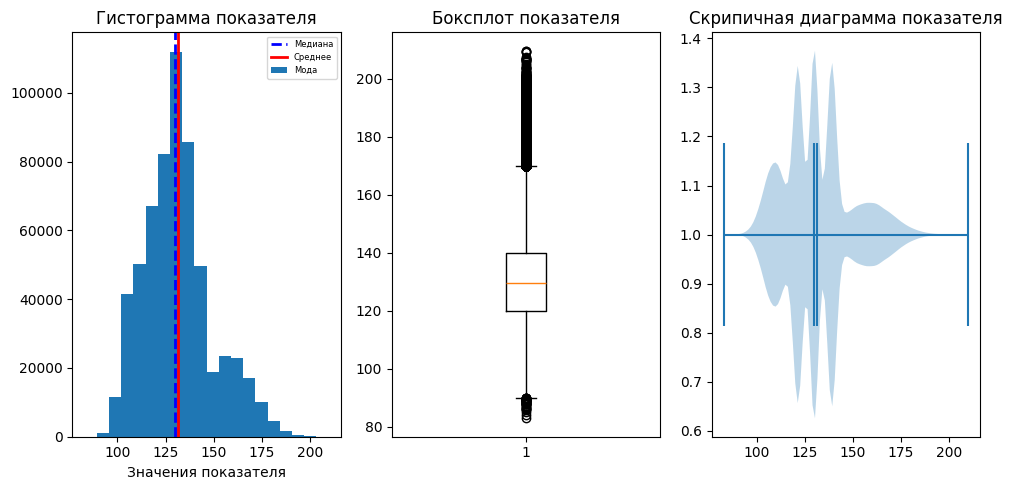

Показатели описательной статистики
count    600000.000000
mean        131.340485
std          17.842450
min          82.918527
25%         119.924094
50%         129.727941
75%         139.915216
max         209.673650
Name: resting_blood_pressure, dtype: float64
Мода в данных по показателю: 0     104.580189
1     114.119660
2     120.154046
3     120.185103
4     120.980836
5     121.189015
6     121.239541
7     121.581588
8     122.246625
9     123.439540
10    126.874168
11    128.095890
12    128.675730
13    130.085474
14    131.317122
15    138.412515
16    139.241832
17    139.719545
18    139.922186
19    140.133022
20    140.188382
21    140.754344
22    142.307997
Name: resting_blood_pressure, dtype: float64
----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя maximum_heart_rate_achieved


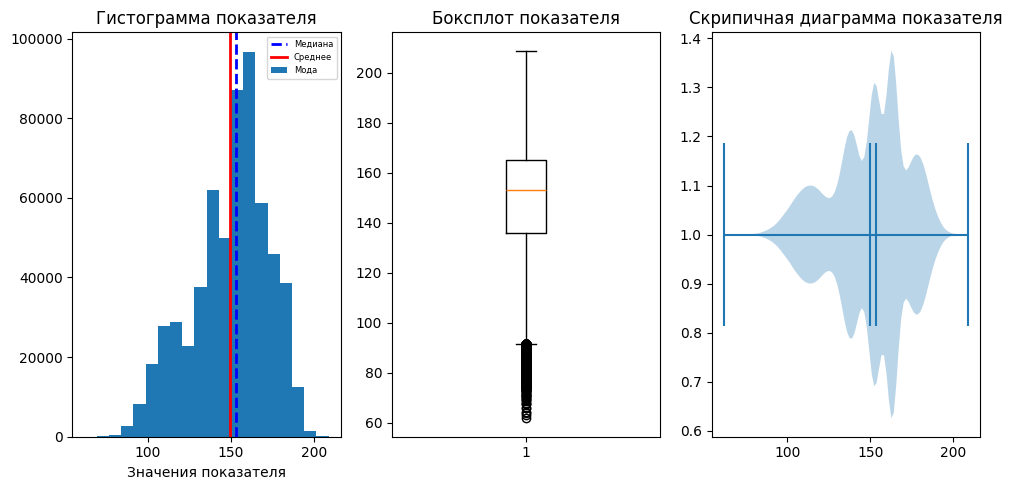

Показатели описательной статистики
count    600000.000000
mean        149.592069
std          23.072593
min          61.844168
25%         135.704237
50%         153.224828
75%         165.165497
max         208.735196
Name: maximum_heart_rate_achieved, dtype: float64
Мода в данных по показателю: 0    138.964749
1    150.653348
2    159.687956
3    163.580150
4    164.278103
5    173.975285
Name: maximum_heart_rate_achieved, dtype: float64
----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя serum_cholestoral


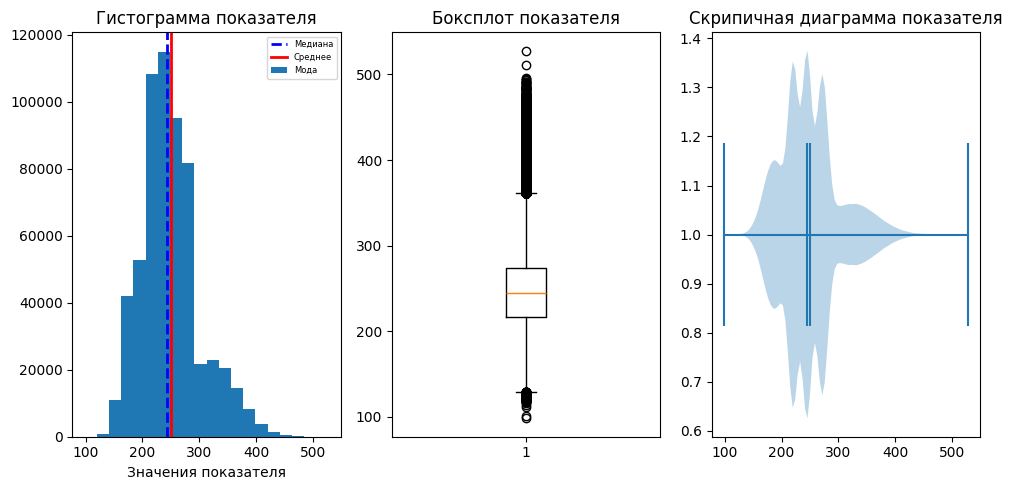

Показатели описательной статистики
count    600000.000000
mean        249.592420
std          51.699976
min          98.326263
25%         216.475964
50%         244.233699
75%         274.345453
max         527.755764
Name: serum_cholestoral, dtype: float64
Мода в данных по показателю: 0    215.183817
1    285.091897
Name: serum_cholestoral, dtype: float64
----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя oldpeak


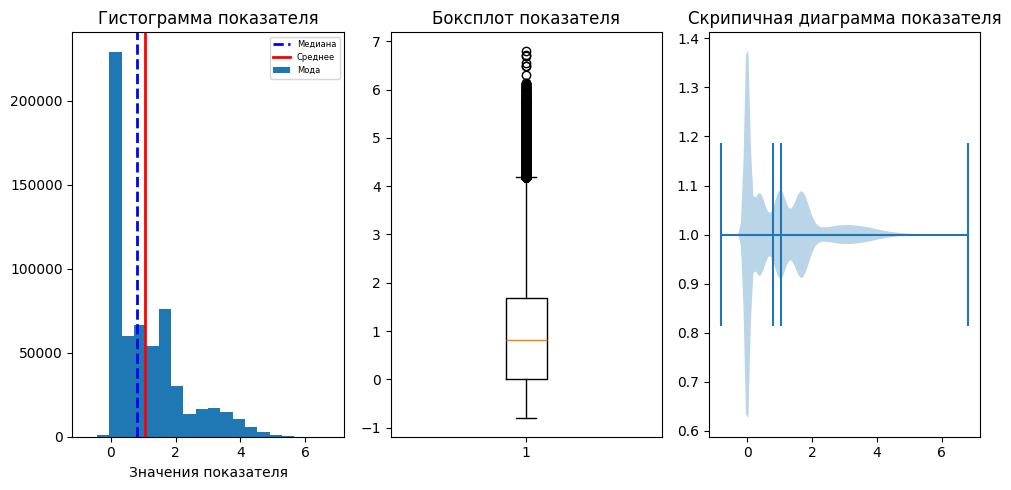

Показатели описательной статистики
count    600000.000000
mean          1.051391
std           1.144288
min          -0.806788
25%           0.000000
50%           0.811101
75%           1.674081
max           6.803372
Name: oldpeak, dtype: float64
Мода в данных по показателю: 0    0.0
Name: oldpeak, dtype: float64
----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя chest


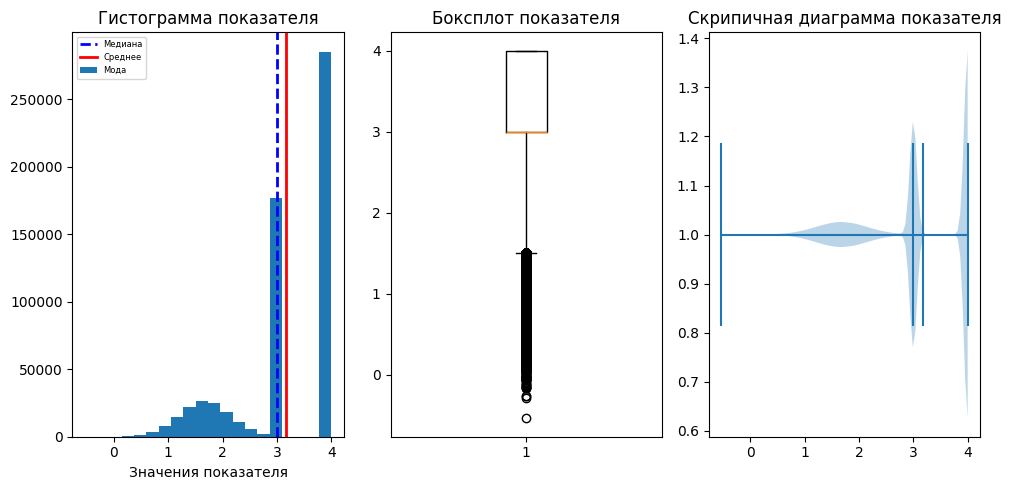

Показатели описательной статистики
count    600000.000000
mean          3.170247
std           0.949618
min          -0.538498
25%           3.000000
50%           3.000000
75%           4.000000
max           4.000000
Name: chest, dtype: float64
Мода в данных по показателю: 0    4.0
Name: chest, dtype: float64
----------------------------------------------------------------------------------------------------


In [32]:
for col in num_col:
  print(f'Исследовательский анализ показателя {col}')
  analisys_num(train[col])
  print('-'*100)

Данные в основном распределены нормально. Но в данных распространено наличие более двух мод, в показателе oldpeak виден сдвиг данных в сторону 0. Аномальных выбросов не обнаружено. Но показатель chest распределен нормально от 0 до 3, но пиками являются 3 и 4. Возможно при внесении данных был применен подход, который не описан в данных, т к этот показатель по описанию похож на категориальный, но описан дробными числами.

Исследовательский анализ показателя sex


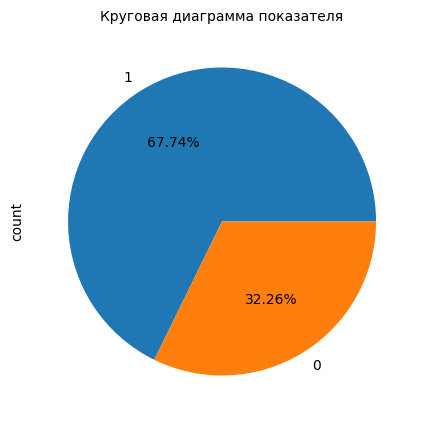

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя fasting_blood_sugar


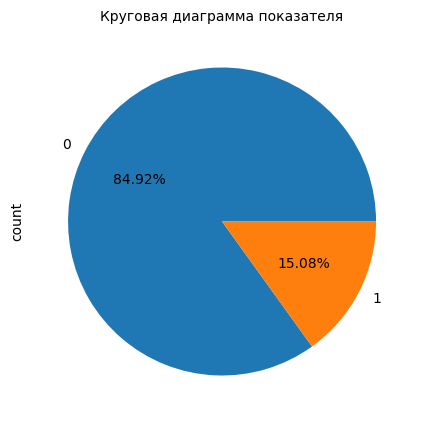

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя exercise_induced_angina


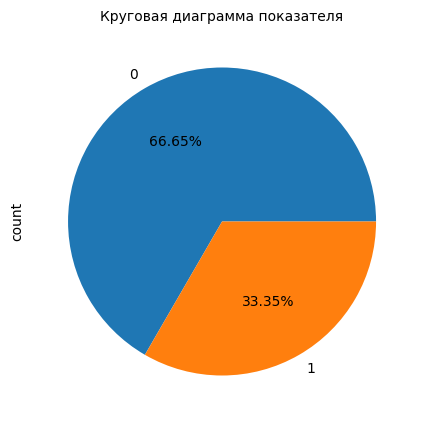

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя class


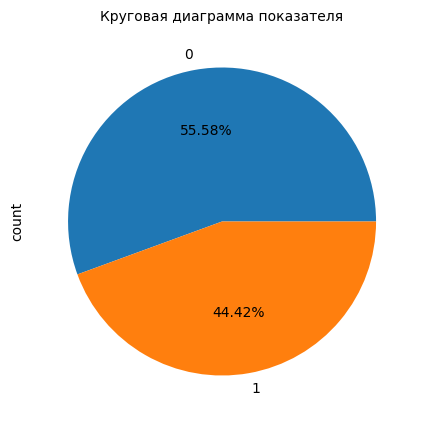

----------------------------------------------------------------------------------------------------


In [33]:
for col in bool_col:
  print(f'Исследовательский анализ показателя {col}')
  analisys_cat_pie(train[col])
  print('-'*100)

Как видно из диаграмм, что в данных примерно половила людей с заболеванием и без. Но в основном показатели крови в норме. В описании данных не была указана расшифровка для колонки "sex". То есть мы не знаем точное распределние представителей разного пола в датасете, но большую часть данных представляют люди, зашифрованные под 1. Предположительно имеется в виду 1 - мужчина, 0 - женщины.

Исследовательский анализ показателя resting_electrocardiographic_results


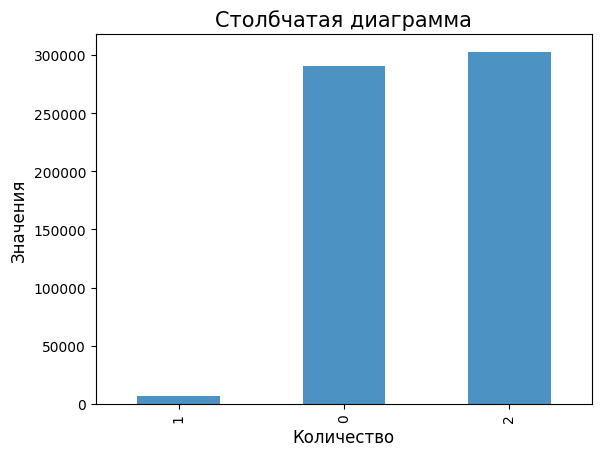

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя slope


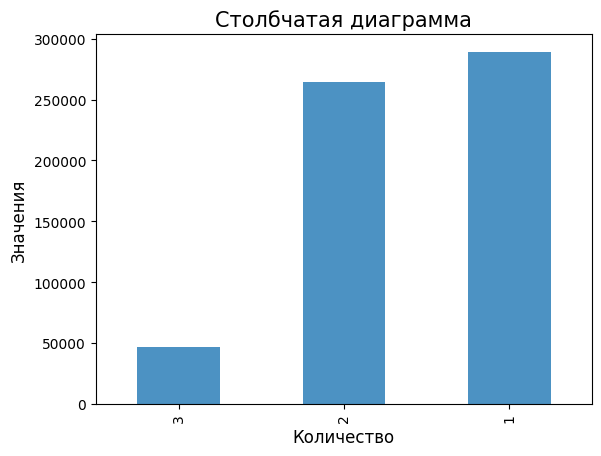

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя number_of_major_vessels


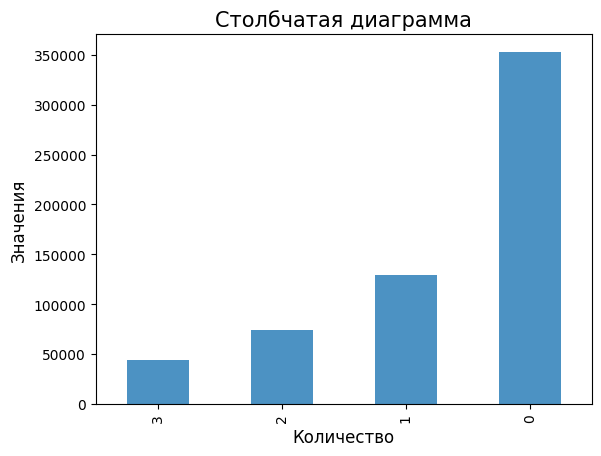

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя thal


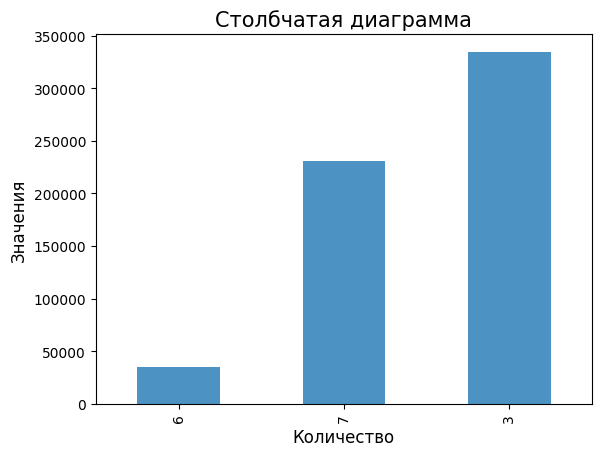

----------------------------------------------------------------------------------------------------


In [34]:
for col in cat_col:
  print(f'Исследовательский анализ показателя {col}')
  analisys_cat_plot(train[col])
  print('-'*100)

*Фактчекинг*

В ЭКГ-исследовании в покое указанные в датасете данные можно итерпритировать следующим образом: 0 - отклонений не обнаружено, 1 - гипертрофия левого желудочка, 2 - возможное наличие ишемии.

Наклон пикового сегмента ST при физической нагрузке можно расшифровать: 1 - подъем сегмента, 2 - горизонтальное положение сегмента, 3 - опускание сегмента.

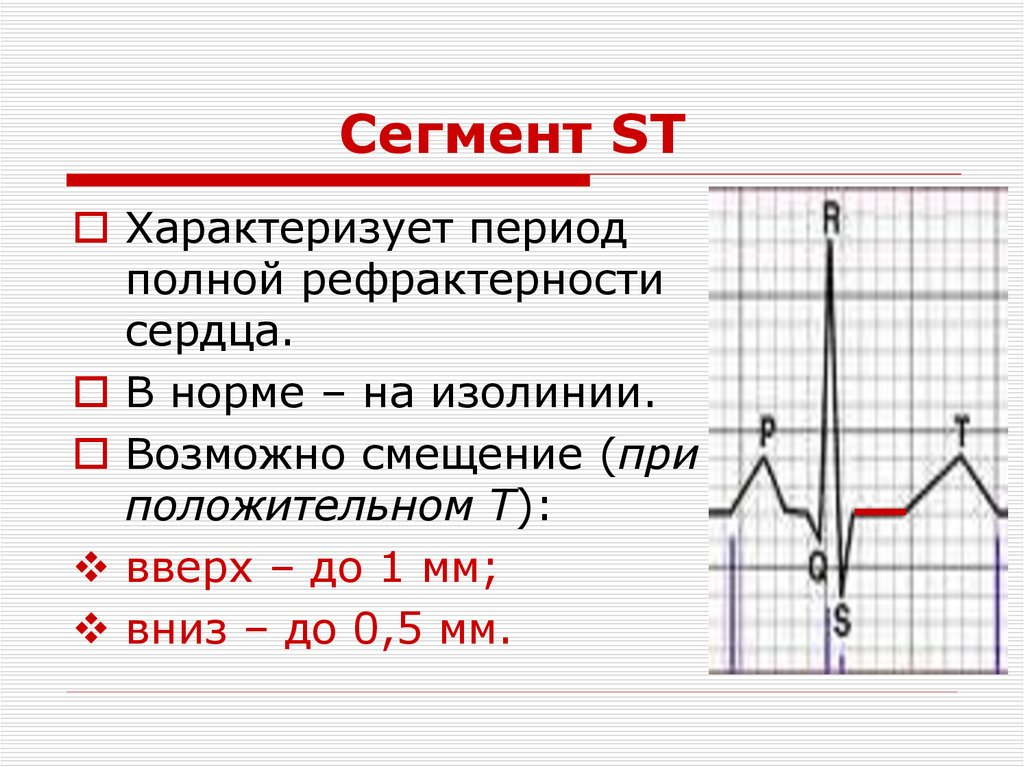

Распределение признака age в группе


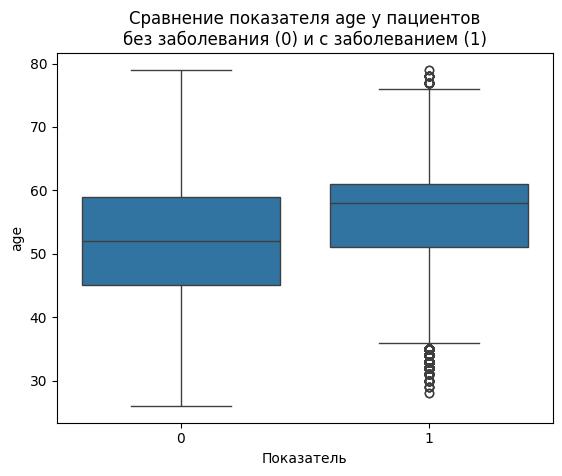

----------------------------------------------------------------------------------------------------
Распределение признака resting_blood_pressure в группе


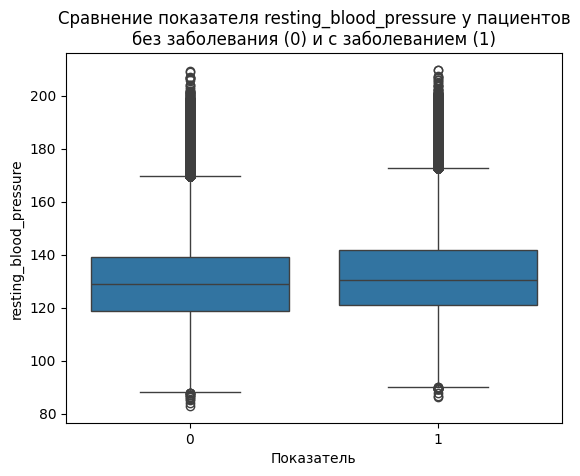

----------------------------------------------------------------------------------------------------
Распределение признака maximum_heart_rate_achieved в группе


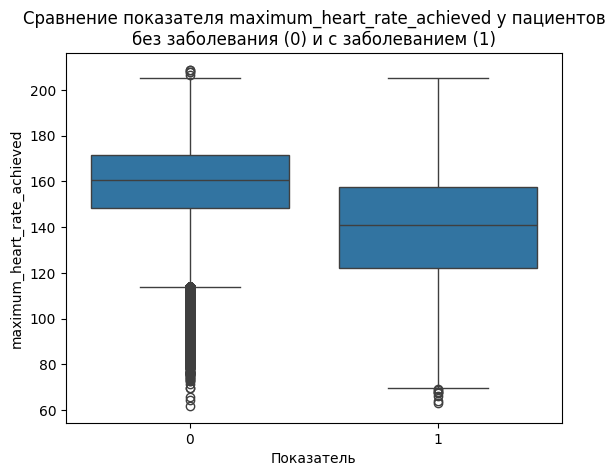

----------------------------------------------------------------------------------------------------
Распределение признака serum_cholestoral в группе


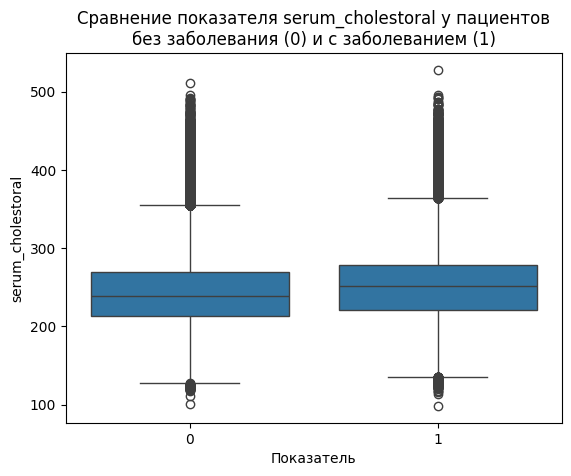

----------------------------------------------------------------------------------------------------
Распределение признака oldpeak в группе


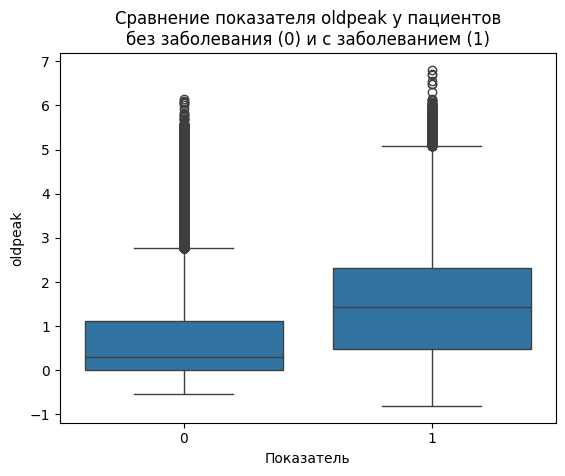

----------------------------------------------------------------------------------------------------
Распределение признака chest в группе


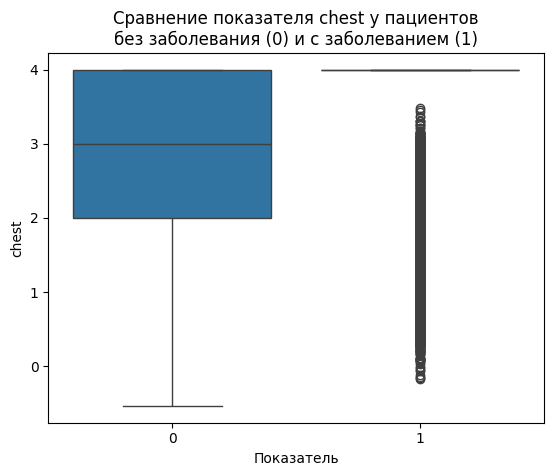

----------------------------------------------------------------------------------------------------


In [35]:
#изучим распределение входных признаков в группах по статусу
for col in num_col:
  print(f'Распределение признака {col} в группе')
  target_sigh(train, 'class', col)
  print('-'*100)

Распределение показателей не имеет сильных отличий между группами.

Изучение взаимосвязи между возрастом и показателем resting_blood_pressure


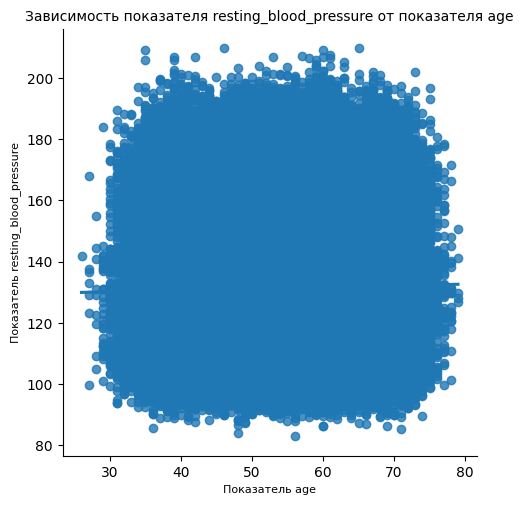

----------------------------------------------------------------------------------------------------
Изучение взаимосвязи между возрастом и показателем chest


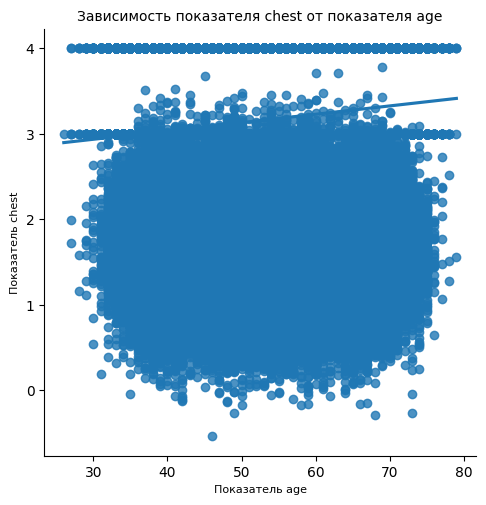

----------------------------------------------------------------------------------------------------
Изучение взаимосвязи между возрастом и показателем maximum_heart_rate_achieved


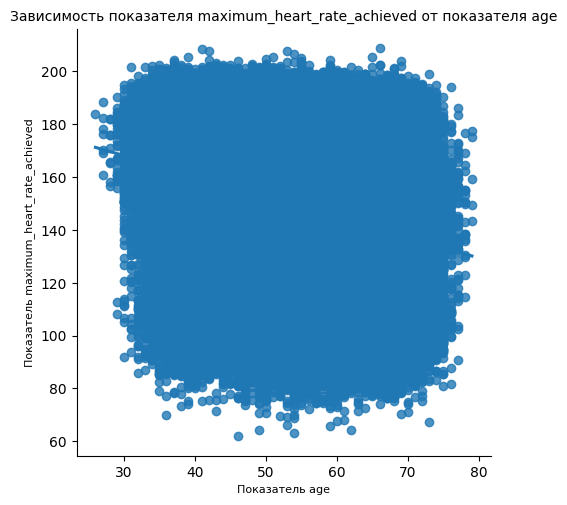

----------------------------------------------------------------------------------------------------
Изучение взаимосвязи между возрастом и показателем serum_cholestoral


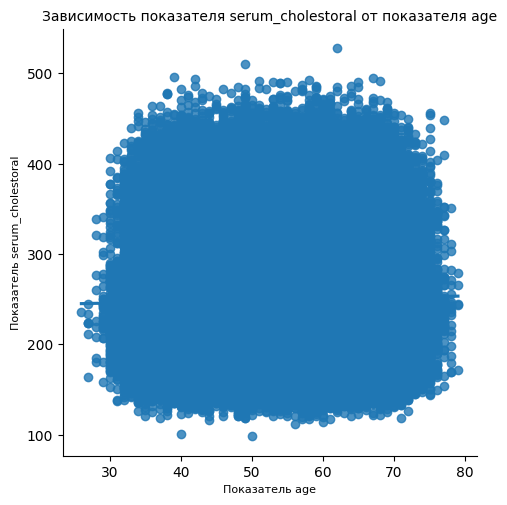

----------------------------------------------------------------------------------------------------
Изучение взаимосвязи между возрастом и показателем oldpeak


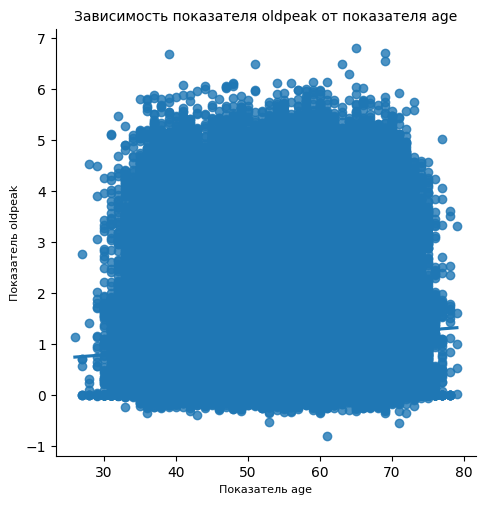

----------------------------------------------------------------------------------------------------


In [36]:
#изучим взаимосвязь количесвтенных показателей с возрастом

#выделим эти столбцы в отдельную переменную и напишем цикл
col_conn = ['resting_blood_pressure', 'chest','maximum_heart_rate_achieved', 'serum_cholestoral', 'oldpeak']

for col in col_conn:
  print(f'Изучение взаимосвязи между возрастом и показателем {col}')
  grafic(train, 'age', col)
  print('-'*100)

<Figure size 1000x600 with 0 Axes>

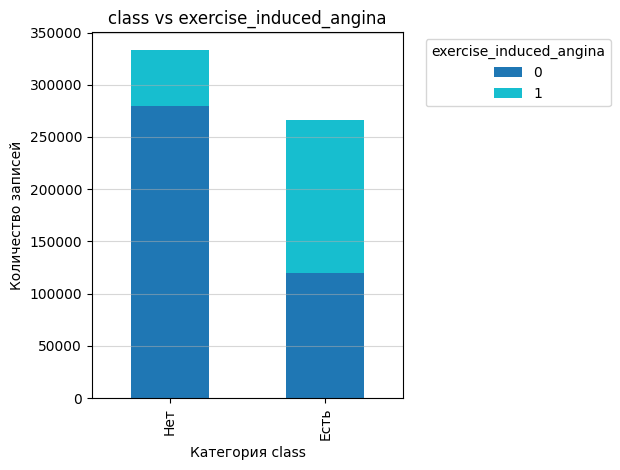

In [37]:
target_group(train, 'class', 'exercise_induced_angina')

Зависимостей между возрастом и показатели не обнаружено.

##Корреляционный анализ

In [38]:
corr_matrix_df = train.drop('ID', axis = 1).corr()

In [39]:
#определим ранг для матрицы и ее определитель
rank = np.linalg.matrix_rank(corr_matrix_df.values)
determinant = np.linalg.det(corr_matrix_df.values)

print(f'Количество признаков {len(train.drop("ID", axis=1).columns)}')
print(f'Ранг матрицы корреляций: {rank}')
print(f'Определитель матрицы корреляций: {determinant:.5f}')

Количество признаков 14
Ранг матрицы корреляций: 14
Определитель матрицы корреляций: 0.14125


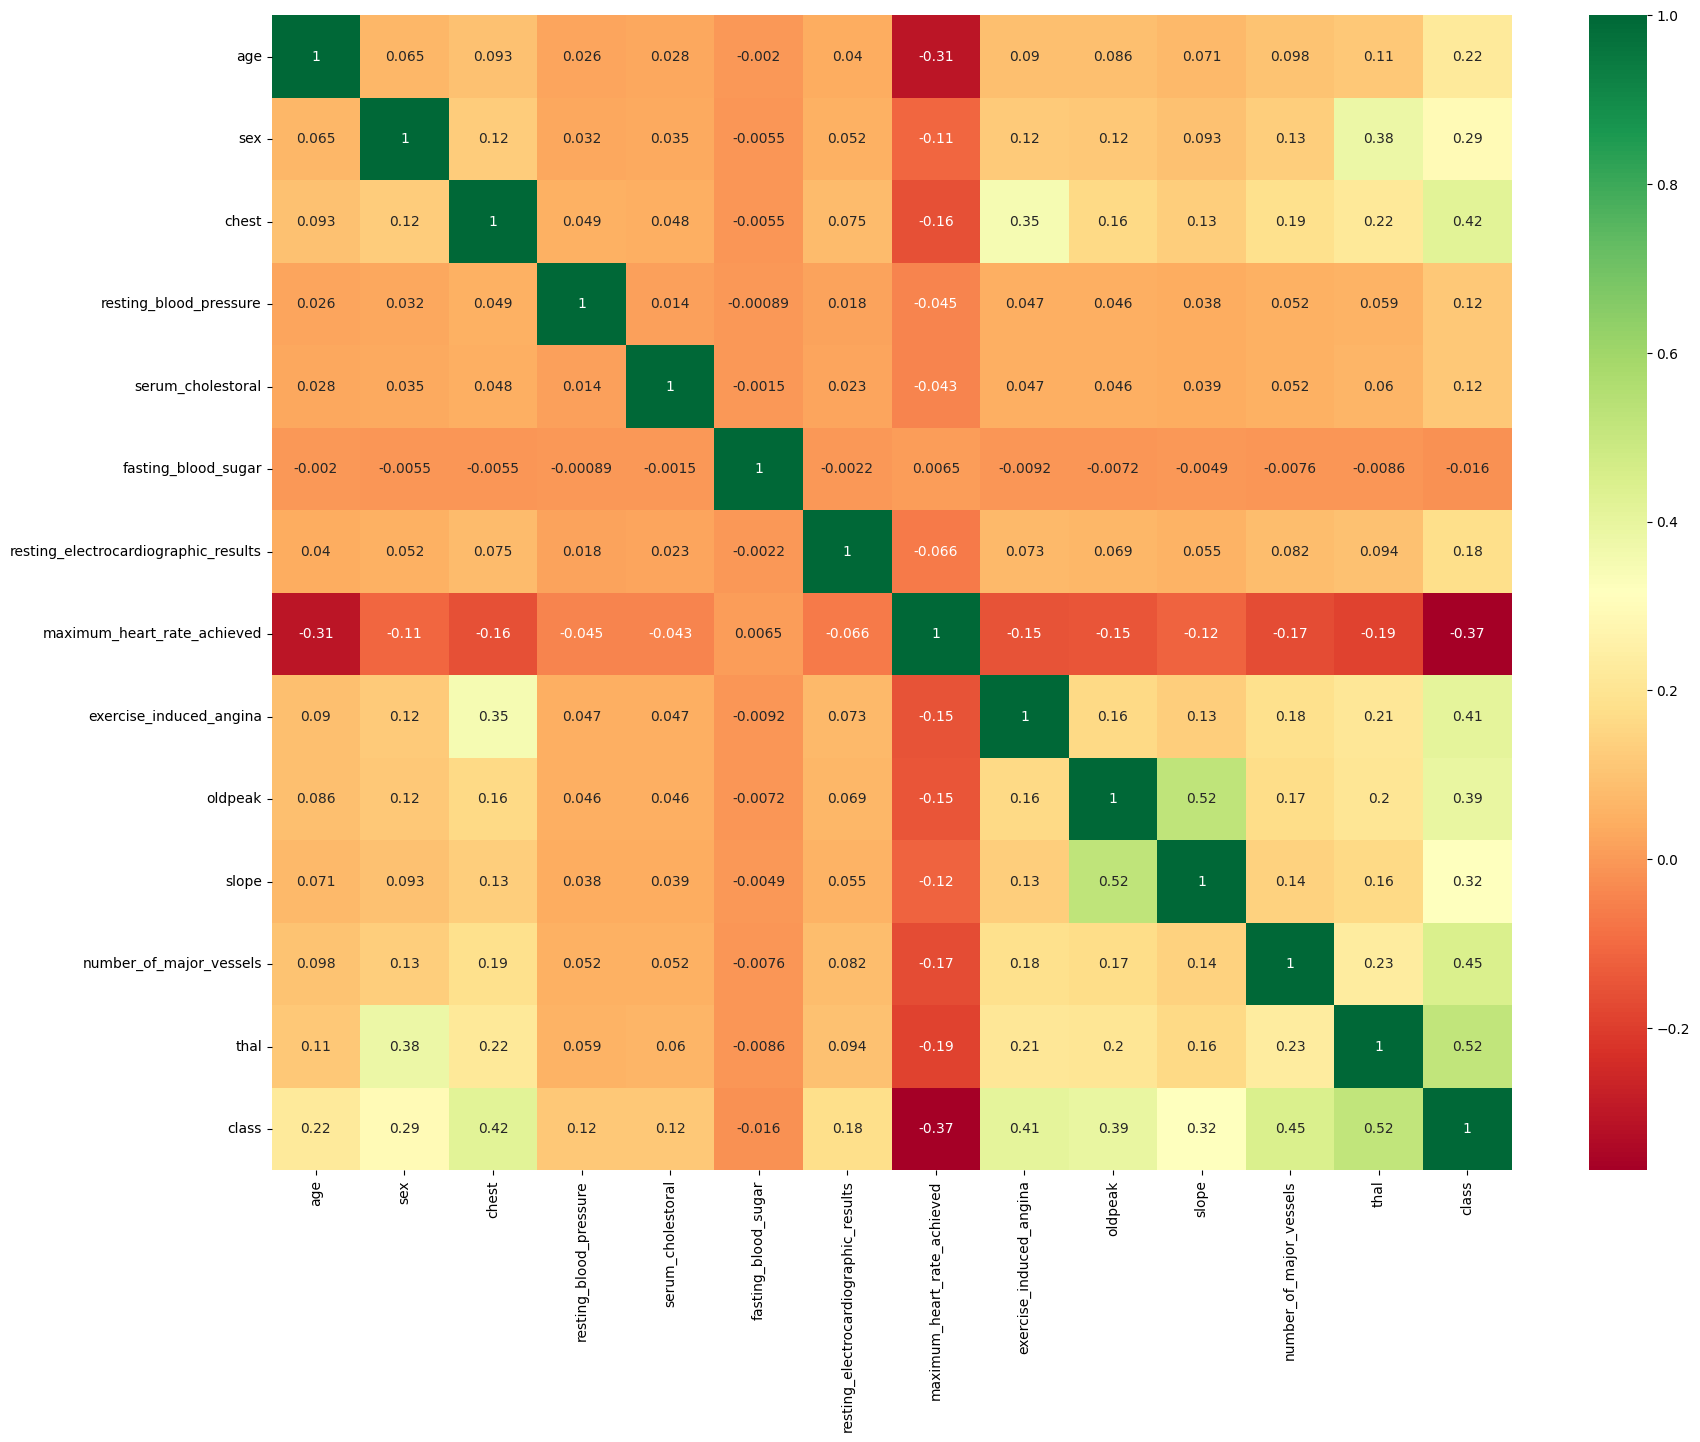

In [40]:
#построим матрицу корреляции
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr_matrix_df, annot=True, cmap='RdYlGn')
plt.show()

##Предподготовка данных

In [41]:
#объявим переменные
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [42]:
#для показателя боль в груди округлим в большую сторону данные
#нужно для перевода в категорию
train['chest'] = np.ceil(train['chest'])
test['chest'] = np.ceil(test['chest'])

In [43]:
y_train = train['class']
X_train = train.drop(['ID', 'class'], axis = 1)

In [44]:
test = test.drop('ID', axis = 1)

In [45]:
scaler = StandardScaler()

In [46]:
columns_to_scale = ['age', 'resting_blood_pressure','serum_cholestoral',
                    'maximum_heart_rate_achieved', 'oldpeak']
other_columns = ['sex', 'chest','fasting_blood_sugar','resting_electrocardiographic_results',
                 'exercise_induced_angina', 'slope', 'number_of_major_vessels', 'thal']

In [47]:
X_train_scaler = scaler.fit_transform(X_train[columns_to_scale])
test_scaler = scaler.transform(test[columns_to_scale])

In [48]:
X_train_scaler = pd.DataFrame(X_train_scaler, index=X_train.index, columns=columns_to_scale)
test_scaler = pd.DataFrame(test_scaler, index=test.index, columns=columns_to_scale)

In [49]:
X_train = pd.concat([X_train_scaler, X_train[other_columns]], axis=1)
test = pd.concat([test_scaler, test[other_columns]], axis=1)

In [50]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=TEST_SIZE,
                                                    random_state= RANDOM_STATE, stratify=y_train)

##Обучение моделей


In [51]:
easy_lr = LogisticRegression(random_state=RANDOM_STATE)
easy_lr.fit(X_train, y_train)
y_pred_lr = easy_lr.predict(X_val)
accuracy_lr = round(accuracy_score(y_val, y_pred_lr), 4)
print(f'Правильность для базовой логистической регрессии: {accuracy_lr}')

Правильность для базовой логистической регрессии: 0.8804


Оценка ROC-AUC на тестовых данных для лучшей модели
Значение ROC-AUC на тестовых данных: 0.9492


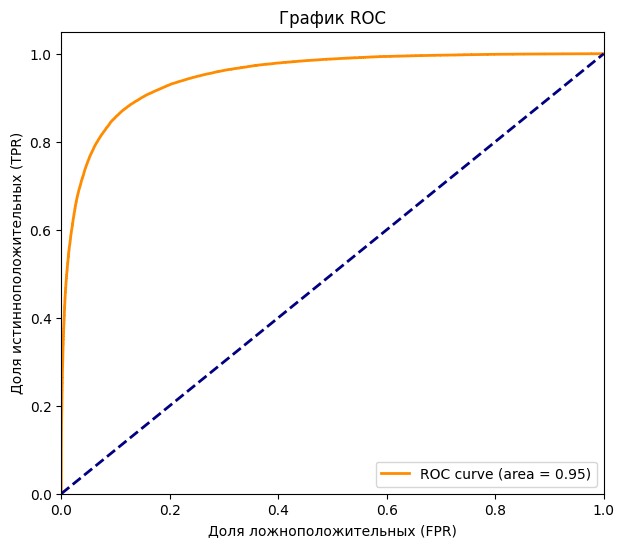

Построение матрицы ошибок для лучшей модели


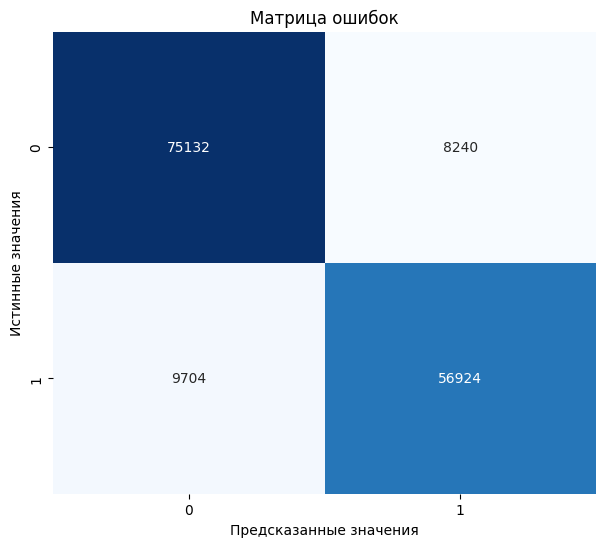

In [52]:
score_model(easy_lr, X_val, y_val)

In [53]:
lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

In [54]:
param_lr = {
    'C': uniform(loc=0.1, scale=10),
    'solver': ['newton-cg', 'lbfgs'],
    'penalty': ['l2']
}

In [55]:
%%time
random_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_lr,
    n_iter= 5,
    cv=3,
    n_jobs=-1,
    scoring='accuracy')

random_search_lr.fit(X_train, y_train)
lr_best = random_search_lr.best_estimator_
best_score_lr = round(random_search_lr.best_score_, 4)

print('Лучшая модель и её параметры:\n\n', lr_best)
print('Параметры лучшей модели:\n', random_search_lr.best_params_)
print(f'\n\nМетрика правильности на кросс-валидационной выборке:', best_score_lr)

Лучшая модель и её параметры:

 LogisticRegression(C=np.float64(5.4274527022447225), max_iter=1000,
                   random_state=42, solver='newton-cg')
Параметры лучшей модели:
 {'C': np.float64(5.4274527022447225), 'penalty': 'l2', 'solver': 'newton-cg'}


Метрика правильности на кросс-валидационной выборке: 0.8802
CPU times: user 3.41 s, sys: 195 ms, total: 3.6 s
Wall time: 17.5 s


In [56]:
y_pred_lr_s = lr_best.predict(X_val)
accuracy_lr_s = accuracy_score(y_val, y_pred_lr_s)

Оценка ROC-AUC на тестовых данных для лучшей модели
Значение ROC-AUC на тестовых данных: 0.9492


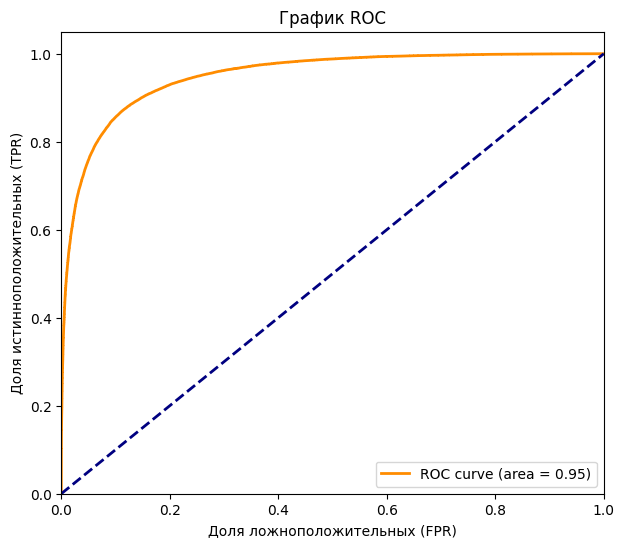

Построение матрицы ошибок для лучшей модели


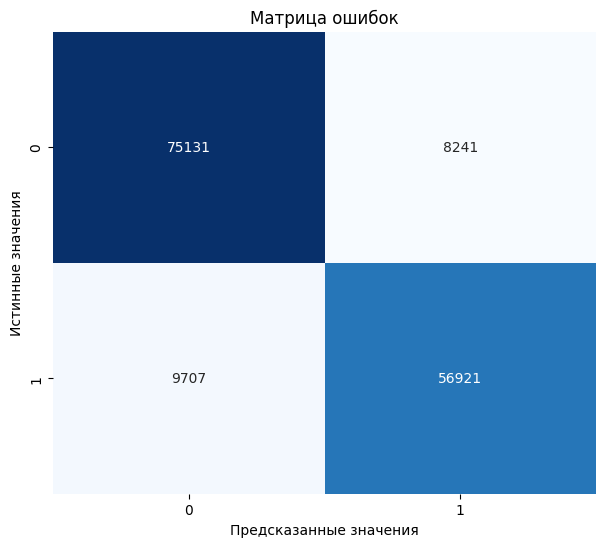

In [57]:
score_model(lr_best, X_val, y_val)

In [58]:
easy_forest = RandomForestClassifier()

easy_forest.fit(X_train, y_train)

y_pred_f= easy_forest.predict(X_val)
accuracy_f= accuracy_score(y_val, y_pred_f)
print(f'Правильность для базовой логистической регрессии: {accuracy_f}')

Правильность для базовой логистической регрессии: 0.89734


Оценка ROC-AUC на тестовых данных для лучшей модели
Значение ROC-AUC на тестовых данных: 0.9600


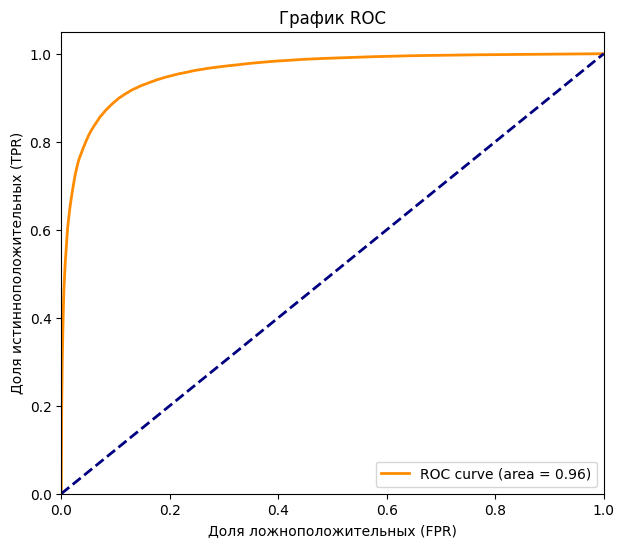

Построение матрицы ошибок для лучшей модели


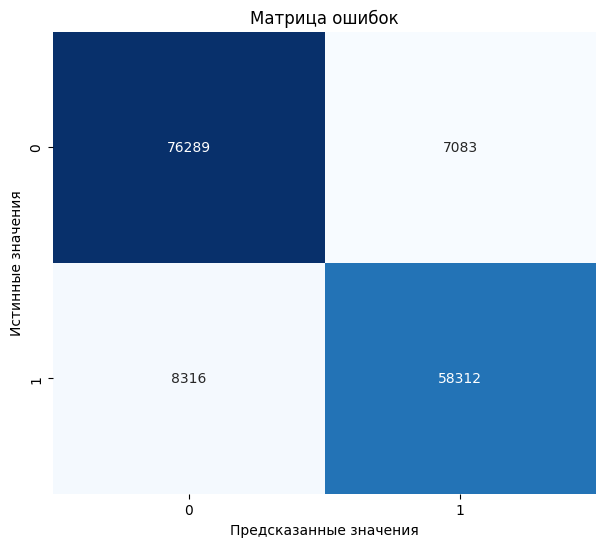

In [59]:
score_model(easy_forest, X_val, y_val)

In [60]:
forest = RandomForestClassifier()

In [61]:
forest_param = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'bootstrap': [True, False]
}

In [62]:
%%time
random_search_forest = RandomizedSearchCV(
    estimator=forest,
    param_distributions=forest_param,
    n_iter=3,
    cv=2,
    scoring='accuracy')

random_search_forest.fit(X_train, y_train)

forest_best = random_search_forest.best_estimator_
best_score_forest = round(random_search_forest.best_score_, 4)

print('Лучшая модель и её параметры:\n\n', forest_best)
print('Параметры лучшей модели:\n', random_search_forest.best_params_)
print(f'\n\nМетрика правильности на кросс-валидационной выборке:', best_score_forest)

Лучшая модель и её параметры:

 RandomForestClassifier(min_samples_split=5, n_estimators=200)
Параметры лучшей модели:
 {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': None, 'bootstrap': True}


Метрика правильности на кросс-валидационной выборке: 0.8977
CPU times: user 18min 26s, sys: 3.58 s, total: 18min 30s
Wall time: 18min 42s


In [63]:
#строим модель нейроной сети
model = Sequential([
    Dense(128, input_shape=X_train.shape[1:], activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [64]:
#компилируем модель
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [65]:
history = model.fit(X_train,
                    y_train,
                    epochs=5,
                    validation_data=(X_val, y_val),
                    batch_size= 32)

Epoch 1/5
14063/14063 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.8767 - loss: 0.3392 - val_accuracy: 0.8904 - val_loss: 0.2661
Epoch 2/5
14063/14063 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.8944 - loss: 0.2569 - val_accuracy: 0.8963 - val_loss: 0.2522
Epoch 3/5
14063/14063 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - accuracy: 0.8966 - loss: 0.2511 - val_accuracy: 0.8950 - val_loss: 0.2539
Epoch 4/5
14063/14063 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - accuracy: 0.8975 - loss: 0.2495 - val_accuracy: 0.8965 - val_loss: 0.2496
Epoch 5/5
14063/14063 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - accuracy: 0.8971 - loss: 0.2490 - val_accuracy: 0.8973 - val_loss: 0.2492


In [66]:
max_accuracy = max(history.history['accuracy'])

##Выбор лучшей модели

In [67]:
models = ['Простая лог регрессия', 'Лог регрессия',
          'Простой случ лес', 'Случ лес',
          'Нейронная сеть']
metrics = {'accuracy' : [accuracy_lr, best_score_lr,
                         accuracy_f, best_score_forest,
                         max_accuracy]}

b_m = pd.DataFrame(metrics, index=models)

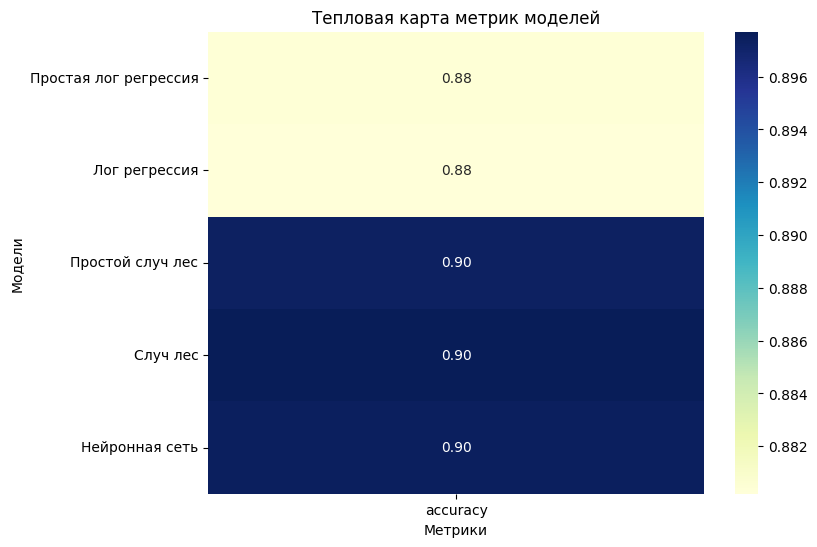

In [68]:
#выведем тепловую карту
plt.figure(figsize=(8, 6))
sns.heatmap(b_m, annot=True, fmt='.2f', cmap='YlGnBu', cbar=True)
plt.title('Тепловая карта метрик моделей')
plt.xlabel('Метрики')
plt.ylabel('Модели')
plt.show()

##Получение прогноза

Т к на данный момент невозможно выделить лучшую модель, получим прогноз с помощью нейронной сети.

In [69]:
predictions = model.predict(test)

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step


In [70]:
predictions

array([[0.9866227 ],
       [0.9795074 ],
       [0.02519894],
       ...,
       [0.07936495],
       [0.05687504],
       [0.9954124 ]], dtype=float32)

##Общие выводы

Как видно, при кросс-валидации и валидационных данных получаем метркии accuracy более 0.8. Но при подробном изучении метрик accuracy, ROC-AUC и матрицы ошибок есть предположение о переобучении модели. Вероятно что данные используемые для обучения и, следовательно, валидации имеют похожую структуру.

Цель на будущее: необходимо выбрать одну модель и попробовать поработать с весами.

Т к в рамках тестовых данный не переданы целевые признаки, то сделать полноценные выводы о моделях.

In [71]:
print('Код не упал!')

Код не упал!
